In [1]:
# Importation of Librairies

import arviz as az
import numpy as np
import xarray as xr
import pandas as pd
import pymc as pm
import pylab as pl
import pytensor
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import *
import warnings
warnings.filterwarnings("ignore")
import pytensor.tensor as pt
import os
import seaborn as sns ; sns.set();

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.optimize import least_squares
from scipy.integrate import odeint

print(f"Runing PyMC v{pm.__version__}")

Runing PyMC v5.10.4


In [2]:
# Importation of Data
data_path = '/content/drive/MyDrive/owid-covid-data.csv'
data = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/owid-covid-data.csv'))
df=data[data['iso_code']=='MYS']
time = np.arange(0, df.iloc[416:1555-25,:].shape[0])
Time = df.date[416:1555-25]
df_n = np.array(df['population'][416:1555-25])
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
206090,MYS,Asia,Malaysia,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,42.4,NaN,1.9,76.16,0.81,33938216.0,NaN,NaN,NaN,NaN
206091,MYS,Asia,Malaysia,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,42.4,NaN,1.9,76.16,0.81,33938216.0,NaN,NaN,NaN,NaN
206092,MYS,Asia,Malaysia,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,42.4,NaN,1.9,76.16,0.81,33938216.0,NaN,NaN,NaN,NaN
206093,MYS,Asia,Malaysia,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,42.4,NaN,1.9,76.16,0.81,33938216.0,NaN,NaN,NaN,NaN
206094,MYS,Asia,Malaysia,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,42.4,NaN,1.9,76.16,0.81,33938216.0,NaN,NaN,NaN,NaN


In [ ]:
# # Importation of Data
# data_path = '/content/drive/MyDrive/owid-covid-data.csv'
# data = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/owid-covid-data.csv'))
# df=data[data['iso_code']=='CAN']
# time = np.arange(0, df.iloc[352:1555-438,:].shape[0])
# Time = df.date[352:1555-438]
# df_n = np.array(df['population'][352:1555-438])
# df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
59147,CAN,North America,Canada,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,16.6,NaN,2.5,82.43,0.929,38454328.0,-205.1,-3.2,-3.2,-5.413223
59148,CAN,North America,Canada,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,16.6,NaN,2.5,82.43,0.929,38454328.0,NaN,NaN,NaN,NaN
59149,CAN,North America,Canada,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,16.6,NaN,2.5,82.43,0.929,38454328.0,NaN,NaN,NaN,NaN
59150,CAN,North America,Canada,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,16.6,NaN,2.5,82.43,0.929,38454328.0,NaN,NaN,NaN,NaN
59151,CAN,North America,Canada,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,16.6,NaN,2.5,82.43,0.929,38454328.0,NaN,NaN,NaN,NaN


In [3]:
daf = df.iloc[416:1555-25,:][['new_cases_smoothed','total_cases' , 'total_deaths', 'hosp_patients' ,'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'population']]
daf

,new_cases_smoothed,total_cases,total_deaths,hosp_patients,total_vaccinations,people_vaccinated,people_fully_vaccinated,population
206506,2757.143,283569.0,1051.0,2575.0,69.0,66.0,3.0,33938216.0
206507,2757.143,283569.0,1051.0,2435.0,1221.0,1216.0,5.0,33938216.0
206508,2757.143,283569.0,1051.0,2473.0,5337.0,5329.0,8.0,33938216.0
206509,2757.143,283569.0,1051.0,2417.0,12063.0,12049.0,14.0,33938216.0
206510,2454.714,300752.0,1121.0,2331.0,18789.0,18769.0,20.0,33938216.0
...,...,...,...,...,...,...,...,...
207615,92.143,5276312.0,37348.0,37.0,72653316.0,28138041.0,27550907.0,33938216.0
207616,81.143,5276880.0,37348.0,16.0,72653352.0,28138041.0,27550910.0,33938216.0
207617,81.143,5276880.0,37348.0,27.0,72653401.0,28138043.0,27550912.0,33938216.0
207618,81.143,5276880.0,37348.0,10.0,72653434.0,28138043.0,27550914.0,33938216.0


In [ ]:
# daf = df.iloc[352:1555-438,:][['new_cases_smoothed','total_cases' , 'total_deaths', 'hosp_patients' ,'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'population']]
# daf

,new_cases_smoothed,total_cases,total_deaths,hosp_patients,total_vaccinations,people_vaccinated,people_fully_vaccinated,population
59499,6643.429,495343.0,13947.0,3927.0,26877.0,26876.0,1.0,38454328.0
59500,6643.429,495343.0,13947.0,3881.0,35570.0,35569.0,1.0,38454328.0
59501,6643.429,495343.0,13947.0,3833.0,45773.0,45772.0,1.0,38454328.0
59502,6643.429,495343.0,13947.0,4006.0,48826.0,48825.0,1.0,38454328.0
59503,6643.429,495343.0,13947.0,4176.0,48841.0,48840.0,1.0,38454328.0
...,...,...,...,...,...,...,...,...
60259,2399.429,4526267.0,49361.0,5305.0,96851120.0,34732101.0,31755799.0,38454328.0
60260,1953.429,4539941.0,49663.0,5289.0,96858746.0,34732494.0,31756227.0,38454328.0
60261,1953.429,4539941.0,49663.0,5452.0,96871790.0,34738250.0,31756939.0,38454328.0
60262,1953.429,4539941.0,49663.0,5343.0,96882972.0,34740172.0,31757341.0,38454328.0


In [4]:
missing_values = daf.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

Missing values per column:
new_cases_smoothed          0
total_cases                 0
total_deaths                0
hosp_patients               2
total_vaccinations          6
people_vaccinated          27
people_fully_vaccinated     6
population                  0
dtype: int64


In [5]:
daf = daf.fillna(daf.mean())

daf

,new_cases_smoothed,total_cases,total_deaths,hosp_patients,total_vaccinations,people_vaccinated,people_fully_vaccinated,population
206506,2757.143,283569.0,1051.0,2575.0,69.0,66.0,3.0,33938216.0
206507,2757.143,283569.0,1051.0,2435.0,1221.0,1216.0,5.0,33938216.0
206508,2757.143,283569.0,1051.0,2473.0,5337.0,5329.0,8.0,33938216.0
206509,2757.143,283569.0,1051.0,2417.0,12063.0,12049.0,14.0,33938216.0
206510,2454.714,300752.0,1121.0,2331.0,18789.0,18769.0,20.0,33938216.0
...,...,...,...,...,...,...,...,...
207615,92.143,5276312.0,37348.0,37.0,72653316.0,28138041.0,27550907.0,33938216.0
207616,81.143,5276880.0,37348.0,16.0,72653352.0,28138041.0,27550910.0,33938216.0
207617,81.143,5276880.0,37348.0,27.0,72653401.0,28138043.0,27550912.0,33938216.0
207618,81.143,5276880.0,37348.0,10.0,72653434.0,28138043.0,27550914.0,33938216.0


In [6]:
daf.shape

(1114, 8)

In [7]:
# Check for remaining missing values
missing_values = daf.isnull().sum()
print(f"Remaining missing values per column:\n{missing_values}")

Remaining missing values per column:
new_cases_smoothed         0
total_cases                0
total_deaths               0
hosp_patients              0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
population                 0
dtype: int64


In [8]:
daf.describe()

,new_cases_smoothed,total_cases,total_deaths,hosp_patients,total_vaccinations,people_vaccinated,people_fully_vaccinated,population
count,1114.000000,1.114000e+03,1114.000000,1114.000000,1.114000e+03,1.114000e+03,1.114000e+03,1114.0
mean,4492.007336,3.810520e+06,29864.050269,2482.558453,5.822567e+07,2.367460e+07,2.265984e+07,33938216.0
std,6471.129582,1.693006e+06,12100.935486,3404.623107,2.409531e+07,8.747911e+06,9.201023e+06,0.0
min,0.000000,2.835690e+05,1051.000000,10.000000,6.900000e+01,6.600000e+01,3.000000e+00,33938216.0
25%,385.429000,2.623816e+06,30309.000000,244.500000,5.361833e+07,2.576315e+07,2.545555e+07,33938216.0
50%,2036.571500,4.781778e+06,36227.500000,879.000000,7.207720e+07,2.809300e+07,2.750682e+07,33938216.0
75%,4993.714000,5.103885e+06,37116.000000,3403.500000,7.262593e+07,2.813419e+07,2.754875e+07,33938216.0
max,28995.857000,5.276880e+06,37348.000000,14753.000000,7.265349e+07,2.813804e+07,2.755092e+07,33938216.0


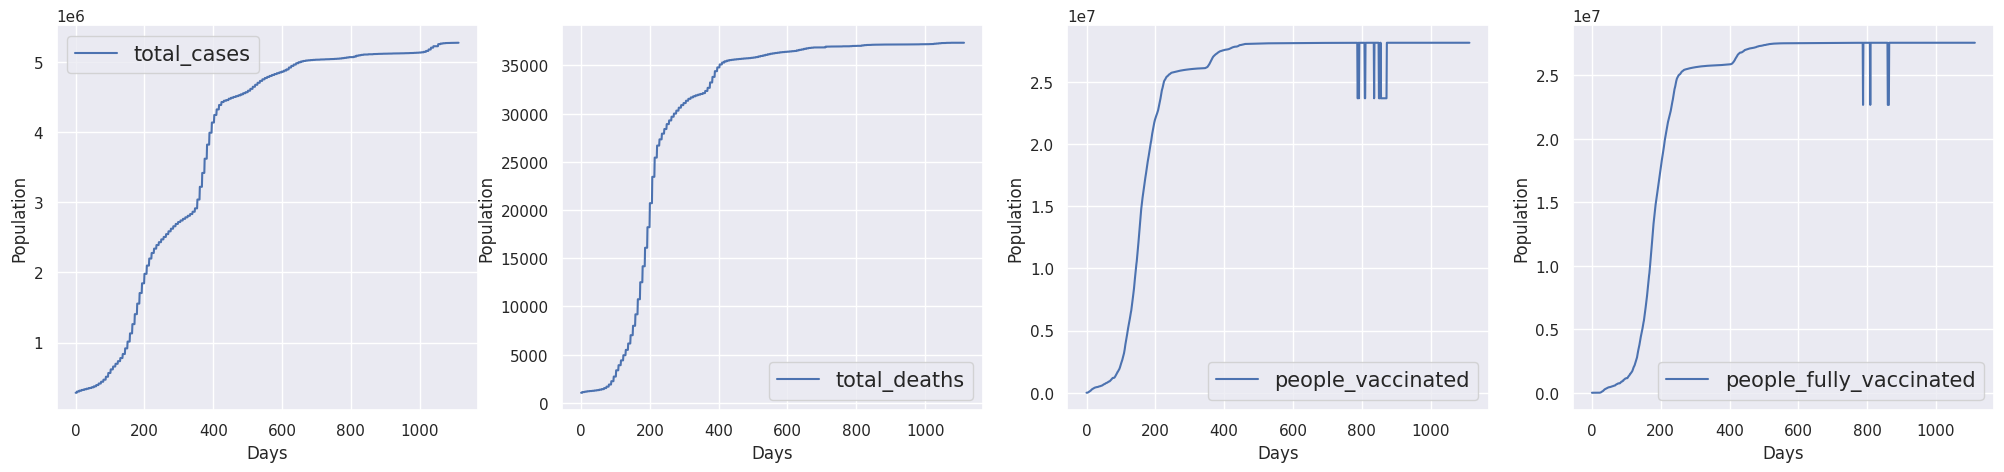

In [9]:
# Plot with a legend
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(25,5))
ax1.plot(time, daf["total_cases"],label="total_cases"); ax1.legend(loc ='best', fontsize=15); ax1.set_xlabel("Days"); ax1.set_ylabel("Population");  ax1.grid(True)
ax2.plot(time, daf["total_deaths"],label="total_deaths"); ax2.set_xlabel("Days"); ax2.set_ylabel("Population"); ax2.legend(loc ='best', fontsize=15); ax2.grid(True)
ax3.plot(time, daf["people_vaccinated"],label="people_vaccinated"); ax3.set_xlabel("Days"); ax3.set_ylabel("Population"); ax3.legend(loc ='best', fontsize=15); ax3.grid(True)
ax4.plot(time, daf["people_fully_vaccinated"],label="people_fully_vaccinated"); ax4.set_xlabel("Days"); ax4.set_ylabel("Population"); ax4.legend(loc ='best', fontsize=15); ax4.grid(True)

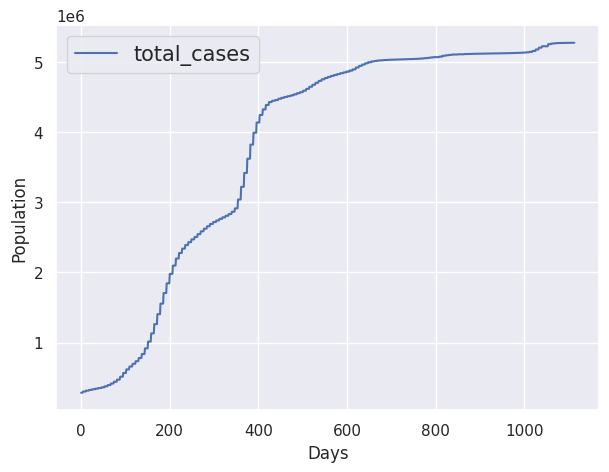

In [10]:
fig , ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(time, daf["total_cases"],label="total_cases"); ax.legend(loc ='best', fontsize=15); ax.set_xlabel("Days"); ax.set_ylabel("Population");  ax.grid(True)
fig.savefig("totatcase.png")

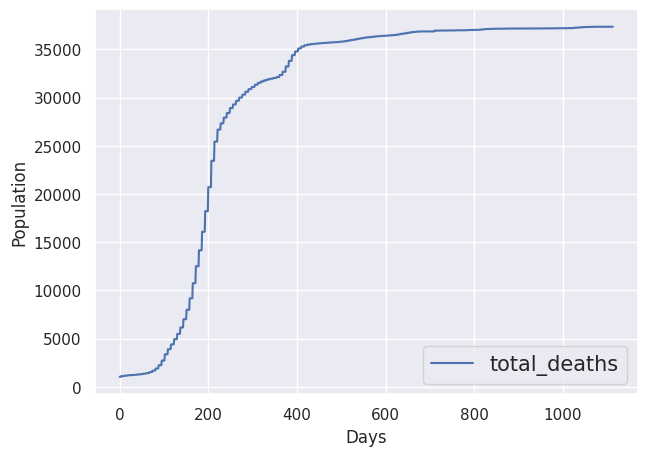

In [11]:
fig , ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(time, daf["total_deaths"],label="total_deaths"); ax.legend(loc ='best', fontsize=15); ax.set_xlabel("Days"); ax.set_ylabel("Population");  ax.grid(True)
fig.savefig("totatdeath.png")

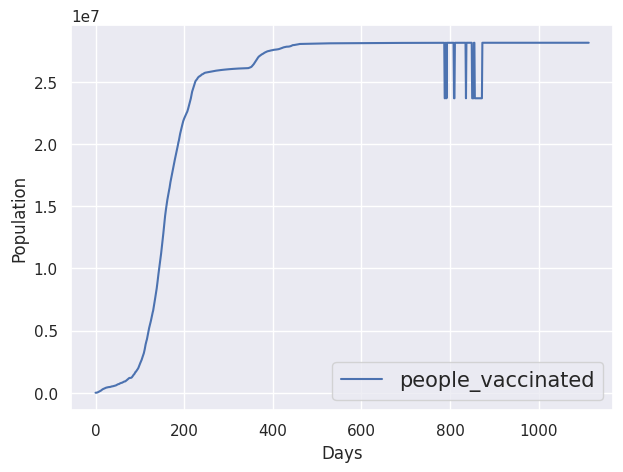

In [12]:
fig , ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(time, daf["people_vaccinated"],label="people_vaccinated"); ax.legend(loc ='best', fontsize=15); ax.set_xlabel("Days"); ax.set_ylabel("Population");  ax.grid(True)
fig.savefig("peoplevaccinated.png")

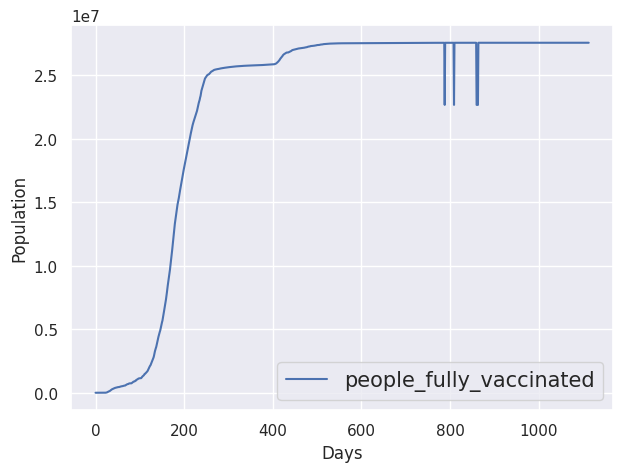

In [13]:
fig , ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(time, daf["people_fully_vaccinated"],label="people_fully_vaccinated"); ax.legend(loc ='best', fontsize=15); ax.set_xlabel("Days"); ax.set_ylabel("Population");  ax.grid(True)
fig.savefig("peoplefullyvaccinated.png")

In [14]:
data_zaf = np.array(daf['new_cases_smoothed'])

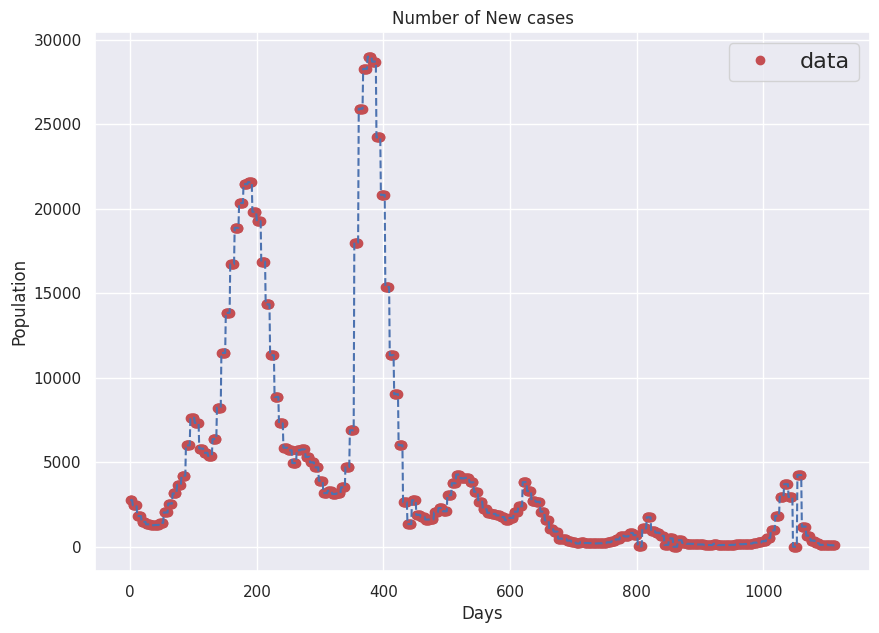

In [15]:
fig, ax  = plt.subplots(1,1, figsize=(10,7))
ax.plot(time, data_zaf, 'ro',label ='data'); ax.legend(loc = 'best', fontsize = 16), ax.grid(True)
ax.plot(time, data_zaf, '--'); ax.set_xlabel("Days"); ax.set_title("Number of New cases"); ax.set_ylabel("Population")
fig.savefig("newcase.png")

In [16]:
# Parameters of the model.

# theta, lambda (alpha, beta_I, beta_A, beta_H), phi, tau, sigma, eta, epsilon, kappa, Phi, rho
# omega, delta,, b, d, mu , N =  mean of the total population during the outbreak

# Known values parameter according to literature.

theta = 1185; alpha = 0.2504; tau = 0.0631; epsi = 1/5.2; omega = 1/15; Phi = 1/15; d = 0.0667; kappa = 0.01;
delta  = 0.034; phi = 0.0982; mu = 1/(75.6 * 365); sigma = 2.8213e-5; b = 0.7621 ; rho = 0.5314; beta_I = 1 ;N = np.mean(df_n); eta =0.1255;

# Unknow parameters to estimate

# p = [beta_A, beta_H]

# states of ODE

# y = [S, V_1, V_2, E, A, I, H, R]

In [17]:
# # Parameters of the model.

# # theta, lambda (alpha, beta_I, beta_A, beta_H), phi, tau, sigma, eta, epsilon, kappa, Phi, rho
# # omega, delta,, b, d, mu , N =  mean of the total population during the outbreak

# # Known values parameter according to literature.

# theta = 1185; alpha = 0.1524; tau = 0.4; epsi = 0.661; omega = 1/15; Phi = 1/15; d = 0.0667; kappa = 0.5; b =0.7621;
# delta  = 0.034; phi = 0.0982; mu = 1/(83.81 * 365); sigma = 2.8213e-5; b = 0.7621 ;  N = np.mean(df_n); eta =0.1255; rho = 0.5314; #beta_I = 1 ;

# # Unknow parameters to estimate

# # p = [beta_A, beta_H]

# # states of ODE

# # y = [S, V_1, V_2, E, A, I, H, R]

In [18]:
# Definition of ODE system to apply least square

def rhs_edo(y,t,p):

    lam = (alpha * (p[0] * y[4] +  y[5] + p[1] * y[6]))/ N
    dS = theta - lam * y[0] - (mu + phi) * y[0] + tau * y[1]
    dV_1 = phi * y[0] -(tau + sigma + mu) * y[1]
    dV_2 = sigma * y[1] -(eta + mu)* y[2]
    dE = lam * y[0] - (epsi + mu)* y[3]
    dA = epsi * (1-kappa) * y[3] - (mu + Phi) * y[4]
    dI = epsi * kappa * y[3] + Phi * (1-rho) * y[4] - (mu + delta + omega) * y[5]
    dH = omega * (1-b) * y[5] -(mu+ delta + d) * y[6]
    dR = omega * b * y[5] + Phi * rho * y[4] + d * y[6] + eta * y[2] -mu * y[7]

    return [dS, dV_1, dV_2, dE, dA, dI, dH, dR]


In [19]:
# Parameters inititalization

#p0 = [0.05, 0.2, 0.3, 0.4, 0.02]
p0 =[0.5, 0.64]

# Initial States

# y0 = [5.9e7, 0, 0, 0, 0, 0, 0, 0]
y0 = [32556143,66 , 3, 70900, 35450, 3545, 30568, 3331]

In [ ]:
# # Parameters inititalization

# #p0 = [0.05, 0.2, 0.3, 0.4, 0.02]
# p0 =[0.75, 0.45, 0.15]

# # Initial States

# # y0 = [5.9e7, 0, 0, 0, 0, 0, 0, 0]
# y0 = [df_n[0]-26876-1-1545*20-15450-1545-10568-831,26876 , 1, 1545*20, 15450, 1545, 10568, 831]

In [ ]:
# theta = 1185; alpha = 0.2503; tau = 0.0631; epsi = 1/5.2; omega = 1/15; Phi = 1/15; d = 0.0667;
# delta  = 0.0034; phi = 0.0982; mu = 1/(75.6 * 365); sigma = 2.8213e-4; b = 0.7621 ; rho = 0.5314; N = 32.7e6;
# # Parameters inititalization

# #p0 = [0.05, 0.2, 0.3, 0.4, 0.02]
# p0 =[0.5, 1., 0.64, 0.95, 0.5]

# # Initial States

# y0 = [N, 60, 3, 70900, 35450, 3545, 30568, 3331]

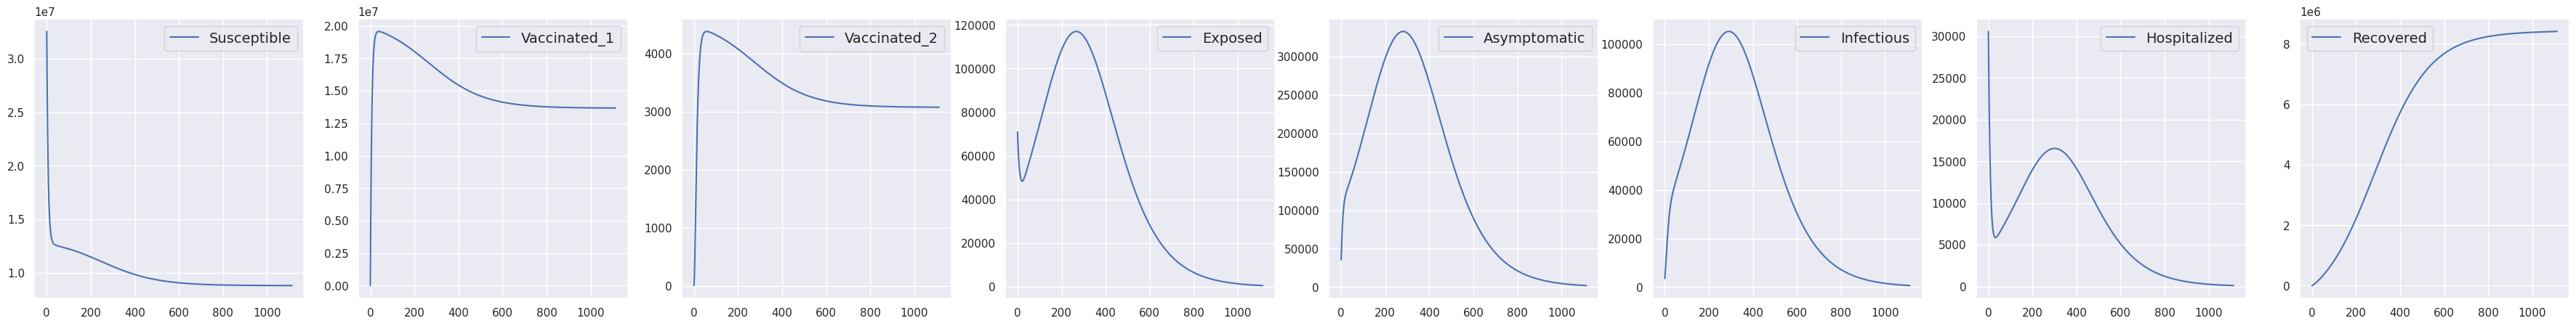

In [20]:
sol = odeint(func=rhs_edo, y0= y0, t=time, args=(p0,))
S = sol[:,0] ; V_1 = sol[:,1] ; V_2 = sol[:,2] ; E = sol[:,3] ; A = sol[:,4] ; I = sol[:,5] ; H = sol[:,6]; R = sol[:,7]
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8, figsize = (45,5))
ax1.plot(time, S, label = 'Susceptible'); ax1.legend(loc = 'best', fontsize =14)
ax2.plot(time, V_1, label = 'Vaccinated_1'); ax2.legend(loc = 'best', fontsize =14)
ax3.plot(time, V_2, label = 'Vaccinated_2'); ax3.legend(loc = 'best', fontsize =14)
ax4.plot(time, E, label = 'Exposed'); ax4.legend(loc = 'best', fontsize =14)
ax5.plot(time, A, label = 'Asymptomatic'); ax5.legend(loc = 'best', fontsize =14)
ax6.plot(time, I, label = 'Infectious'); ax6.legend(loc = 'best', fontsize =14)
ax7.plot(time, H, label = 'Hospitalized'); ax7.legend(loc = 'best', fontsize =14)
ax8.plot(time, R, label = 'Recovered'); ax8.legend(loc = 'best', fontsize =14)

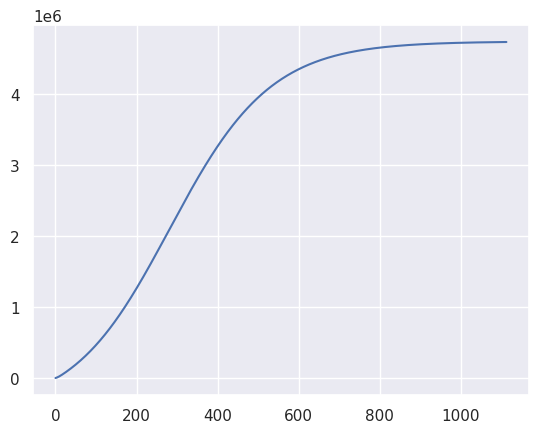

In [21]:
plt.plot(time,np.cumsum((epsi * kappa * odeint(func=rhs_edo, y0= y0, t=time, args=(p0,))[:,3]+
                    Phi * (1-rho) * odeint(func=rhs_edo, y0= y0, t=time, args=(p0,))[:,4])))

In [ ]:
# function that calculates residuals based on a given theta
def ode_model_resid(p):
    return (
        data_zaf - np.cumsum((epsi * kappa * odeint(func=rhs_edo, y0= y0, t=time, args=(p0,))[:,3]+
                    Phi * (1-rho) * odeint(func=rhs_edo, y0= y0, t=time, args=(p0,))[:,4]))
    )

In [ ]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=p0)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["beta_A", "beta_H"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(15)

,Parameter,Least Squares Solution
0,beta_A,0.50
1,beta_H,0.64


In [ ]:
# # calculate least squares using the Scipy solver
# results = least_squares(ode_model_resid, x0=p0)

# # put the results in a dataframe for presentation and convenience
# df = pd.DataFrame()
# parameter_names = ["beta_A", "beta_I", "beta_H"]
# df["Parameter"] = parameter_names
# df["Least Squares Solution"] = results.x
# df.round(15)

,Parameter,Least Squares Solution
0,beta_A,0.75
1,beta_I,0.45
2,beta_H,0.15


In [ ]:
p = results.x
# p=[0.64,]
# p =[0.15, 0.35, 0.65, 0.95, 0.001]

In [ ]:
def error(data_pred, data_real, n ):
  return np.sum(abs(data_pred - data_real))/ n
def NMSE (data_pred, data_real):
    norm_1 = pl.norm(data_real-data_pred,2)
    norm_2 = pl.norm(data_real - np.mean(data_real),2)
    return 1- norm_1 / norm_2

In [ ]:
sol = odeint(rhs_edo,y0=y0, t = time,args=(p,) )
y_pred = ((epsi * kappa * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,3]+
                    Phi * (1-rho) * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,4]))
y_real = data_zaf

Error = error(y_pred, y_real, len(time))
Error

2969.324335159964

In [ ]:
NMSE(y_pred, y_real)

0.2439096709050269

In [ ]:
sol = odeint(rhs_edo,y0=y0, t = time,args=(p,))
y_pred =np.cumsum((epsi * kappa * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,3]+
                    Phi * (1-rho) * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,4]))
y_real = daf['total_cases']

Error = error(y_pred, y_real, len(time))
print('error=', Error)
print('NMSE=', NMSE(y_pred, y_real))

error= 462610.99124736787
NMSE= 0.7026371785689427


In [ ]:
def plot_correlation(data_pred, data_real,t):

    fig , ax = plt.subplots(1,1,figsize=(10,5))

    ax.plot(t, data_pred,'r' , label= 'Predicted values')
    ax.scatter(t, data_real , label = "Real values")
    ax.set_xlabel('Times')
    ax.set_ylabel('Dynamic of population')
    ax.set_title('Results')
    ax.legend(loc='best', fontsize =14)
    ax.grid(True)

In [22]:
# plot_correlation(y_pred, y_real, time)

In [ ]:
# Ode solution

ode_model = DifferentialEquation(
    func = rhs_edo, times = time, n_states = 8, n_theta = 3, t0 = time[0]
)

In [ ]:
theta = p

In [ ]:
# with pm.Model() as model:

      # priors
#     beta_A = pm.TruncatedNormal("beta_A", mu=theta[0], sigma=0.1, lower=0, upper = 1)
#     beta_I = pm.TruncatedNormal("beta_I", mu=theta[1], sigma=0.1, lower=0, upper = 1)
#     beta_H = pm.TruncatedNormal("beta_H", mu=theta[2], sigma=0.1, lower=0, upper = 1)
#     eta = pm.TruncatedNormal("eta", mu=theta[3], sigma=0.1, lower=0, upper = 1)
#     kappa = pm.TruncatedNormal("kappa", mu=theta[4], sigma=0.1, lower=0, upper = 1)

#     # ode_solution
#     ode_solution = ode_model(y0= y0, theta=[beta_A, beta_I, beta_H, eta, kappa])

#     # Likelihood
#     pm.Poisson("Y_obs", mu=(epsi * p[4] * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4]), observed=data_zaf)
#     pm.StudentT("Y_obs", mu = (epsi * p[4] * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4]), sigma= 0.1, nu=50, observed=data_zaf)

In [ ]:
with pm.Model() as model:

    #Priors

    beta_A = pm.Normal("beta_A", mu = theta[0], sigma = 0.01)
    beta_H = pm.Normal("beta_H", mu = theta[1], sigma = 0.01)

    # ODE_solution
    ode_solution = ode_model(y0= y0, theta=[beta_A, beta_H])

    # Likelihood
    pm.Poisson("Y_obs", mu = ((epsi * kappa * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4]))[0], observed=data_zaf)

In [ ]:
sampler = "NUTS PyMC ODE"
tune = 500
draws = 500
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)

In [ ]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_A,0.538,0.000,0.538,0.539,0.0,0.0,293.0,396.0,1.01
beta_H,0.343,0.002,0.339,0.347,0.0,0.0,293.0,379.0,1.02


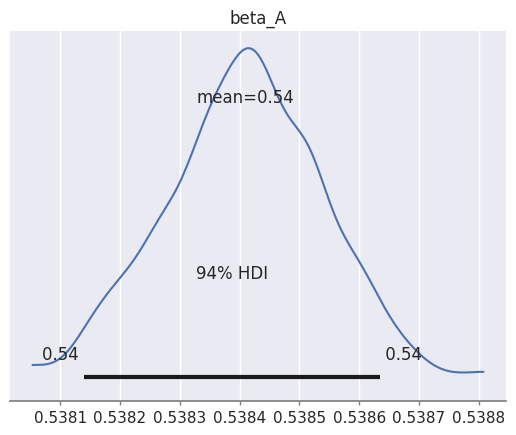

In [ ]:
az.plot_posterior(trace, var_names=['beta_A']);

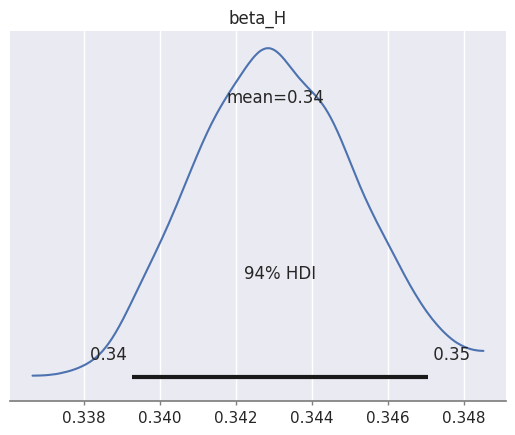

In [ ]:
az.plot_posterior(trace, var_names=['beta_H']);

array([[<Axes: title={'center': 'beta_A'}>,
        <Axes: title={'center': 'beta_A'}>]], dtype=object)

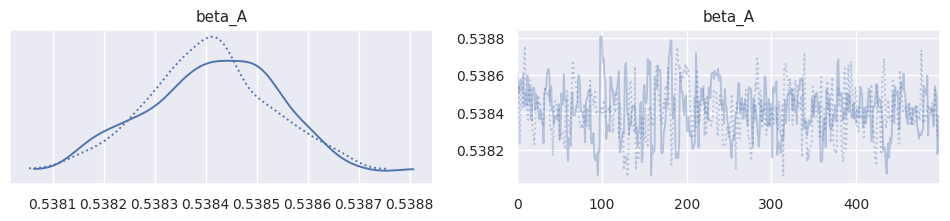

In [ ]:
az.plot_trace(trace, var_names=['beta_A'])

array([[<Axes: title={'center': 'beta_H'}>,
        <Axes: title={'center': 'beta_H'}>]], dtype=object)

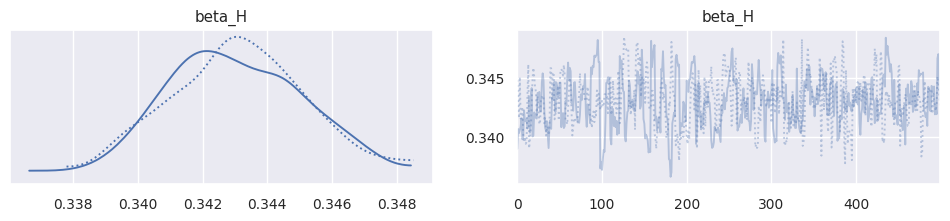

In [ ]:
az.plot_trace(trace, var_names=['beta_H'])

In [ ]:
p =[0.539 	, 0.347]
sol = odeint(rhs_edo,y0=y0, t = time,args=(p,))
y_pred =np.cumsum((epsi * kappa * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,3]+
                    Phi * (1-rho) * odeint(func=rhs_edo, y0= y0, t=time, args=(p,))[:,4]))
y_real = daf['total_cases']

Error = error(y_pred, y_real, len(time))
print('error=', Error)
print('NMSE=',NMSE(y_pred, y_real))

error= 166108.85023839684
NMSE= 0.8761011162907516


In [ ]:
NMSE(y_pred, y_real)

0.8761011162907516

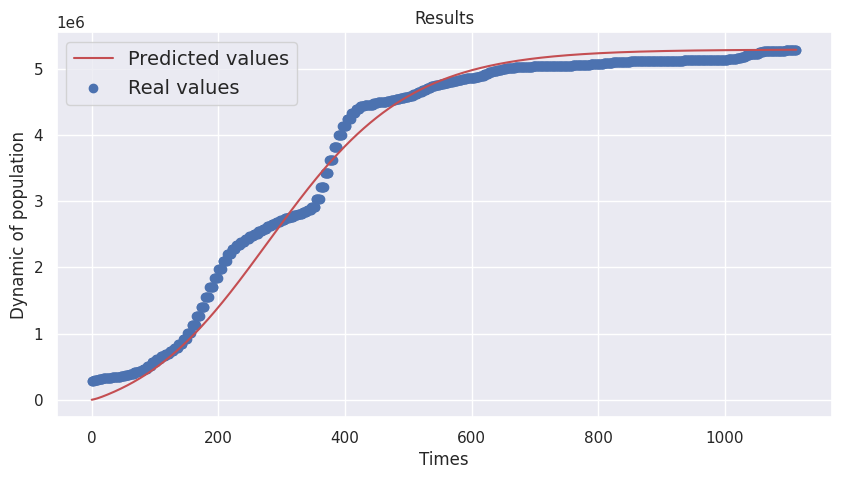

In [ ]:
plot_correlation(y_pred, y_real, time)

In [ ]:
# # Parameters inititalization

# #p0 = [0.05, 0.2, 0.3, 0.4, 0.02]
# p0 =[0.15, 0.35, 0.65, 0.95, 0.001]

# # Initial States

# y0 = [5.9e7, 1130, 113, 0, 0, 2500, 100, 500, df_n[0]]

# theta = 11244; alpha = 1.0598; tau = 0.9; epsi = 0.1961; omega = 0.1; Phi = 1/6; d = 1/14;
# delta  = 0.035; phi = 0.1; mu = 0.0001; sigma = 0.1; b = 0.5 ; rho = 0.5; #N = np.mean(df_n);
# pm.StudentT("Y_obs", mu = (epsi * p[4] * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4]), sigma= 0.01, nu=10, observed=data_zaf)
# NUTS PyMC ODE

In [ ]:
import scipy.stats as stats

# Sample data
data = data_zaf

# Fit different distributions and calculate the best-fit distribution
# You can include additional distributions based on your requirements
distributions = [
    stats.norm,           # Normal distribution
    stats.lognorm,        # Log-normal distribution
    stats.expon,          # Exponential distribution
    stats.weibull_min,    # Weibull distribution
    stats.gamma,          # Gamma distribution
    stats.beta,            # Beta distribution
    stats.t,              # Student's t-distribution
]

best_fit = None
best_fit_params = {}
best_fit_name = ""
best_fit_rss = float('inf')  # Residual sum of squares (initialized to infinity)

# Iterate over distributions and find the best-fit distribution
for distribution in distributions:
    params = distribution.fit(data)

    # Calculate the PDF values for the fitted distribution
    pdf_values = distribution.pdf(data, *params)

    # Calculate the residual sum of squares (RSS) as the measure of fit
    rss = sum((pdf_values - data) ** 2)

    # Update the best-fit distribution if the RSS is lower
    if rss < best_fit_rss:
        best_fit = distribution
        best_fit_params = params
        best_fit_name = distribution.name
        best_fit_rss = rss

print("Best-fit distribution: ", best_fit_name)
print("Parameters: ", best_fit_params)

In [ ]:
(epsi * kappa * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4])

Add.0

In [ ]:
np.cumsum((epsi * kappa * ode_solution[:,3]+  Phi * (1-rho) * ode_solution[:,4]))[0]

Add.0

Estimated parameters:
N = 1000, beta = 0.141, gamma = -0.013


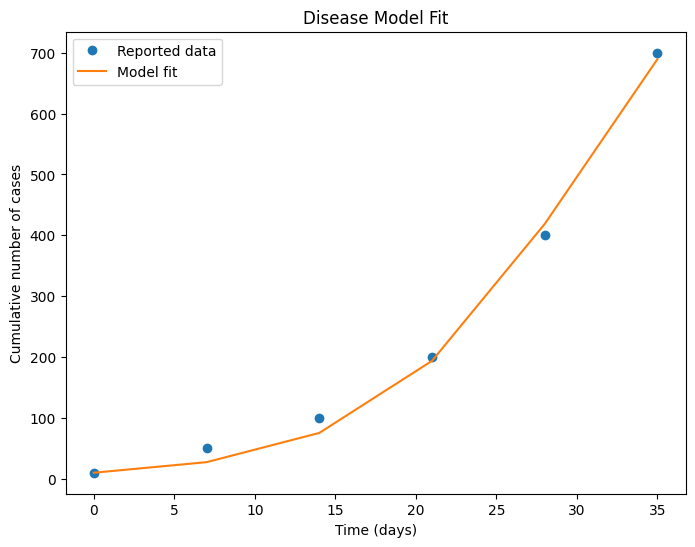

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE model
def disease_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Function to compute the cumulative number of cases
def cumulative_cases(y):
    return y[1] + y[2]

# Least-squares function to estimate the parameters
def least_squares(params, t, data):
    N, beta, gamma = params
    y0 = [N-data[0], data[0], 0]  # Initial conditions
    sol = odeint(disease_model, y0, t, args=(N, beta, gamma))
    model_data = [cumulative_cases(y) for y in sol]
    return np.sum((data - model_data) ** 2)

# Example usage
# Reported cumulative data
t = np.array([0, 7, 14, 21, 28, 35])
data = np.array([10, 50, 100, 200, 400, 700])

# Initial guess for the parameters
N0 = 1000
beta0 = 0.2
gamma0 = 0.1
params0 = [N0, beta0, gamma0]

# Estimate the parameters using least-squares
from scipy.optimize import minimize
res = minimize(least_squares, params0, args=(t, data), method='L-BFGS-B')
N, beta, gamma = res.x

# Print the estimated parameters
print(f"Estimated parameters:\nN = {N:.0f}, beta = {beta:.3f}, gamma = {gamma:.3f}")

# Plot the reported data and the model fit
plt.figure(figsize=(8, 6))
plt.plot(t, data, 'o', label='Reported data')

y0 = [N-data[0], data[0], 0]
sol = odeint(disease_model, y0, t, args=(N, beta, gamma))
plt.plot(t, [cumulative_cases(y) for y in sol], label='Model fit')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative number of cases')
plt.title('Disease Model Fit')
plt.legend()
plt.show()


In [ ]:
k4 = epsi + mu; k5 = 1-kappa; k6= mu+Phi ; k7=1-rho; k8= mu+delta; k9= 1-b; k10= mu+delta+d;
S = theta*(tau+mu+sigma)/(mu*tau+(sigma+mu)*(mu+phi)); N = theta/mu

RA = alpha * S * p[0] * epsi *k5/(N * k4*k6); RI = alpha*S*epsi*(Phi*k5*k7+kappa*k6)/(N*k4*k6*k8);
RH = alpha*S*p[1]*epsi*omega*k9*(Phi*k5*k7+kappa*k6)/(N*k4*k6*k8*k10);
R0 = RA+RI+RH
print("RA=",RA); print("RI=",RI); print("RH=",RH);print("R0=",R0);

RA= 0.5319451489010707
RI= 0.9253682180550514
RH= 0.05055469581381081
R0= 1.5078680627699328
